# PiPCA Demo

PiPCA is a proof of concept Python tool used for exploratory data analysis on experimental LCLS data. This demo will review the functionality of the tool as it exists in its present state.

## Setup and Introductory Analysis

The functionality of PiPCA is accessible through the IPCA class in the btx repository. This tutorial assumes access to SLAC unix servers through the pslogin portal. First we add the relevant repository to our system path.

In [1]:
import sys
sys.path.append("/cds/home/h/hepworth/btx-callum")

Next we import all relevant functions from the ipca and psana_interface classes, as well as additional useful libraries.

In [2]:
from btx.interfaces.psana_interface import *
from btx.processing.ipca import *

import numpy as np

In order to run PiPCA on a dataset one must first initialize an instance of the IPCA class, supplying relevant parameters when necessary including the run number, experiment name, and detector type of said data.

In [3]:
exp = 'amo06516' # experiment name
run = 90 #run number
det_type = 'pnccdFront' # detector name, e.g epix10k2M or jungfrau4M

q = 30 # number of principal components to compute and maintain
n = 150 # total number of images to be incorporated into model
m = 15 # size of image batch incorporated in each model update
start_offset = 100 # run index of first image to be incorporated into iPCA model

With a set of example parameters supplied we now instantiate our PiPCA instance.

In [4]:
ipca = IPCA(exp=exp, run=run, det_type=det_type, start_offset=start_offset, num_components=q, batch_size=m, num_images=n)

User supplied parameters are adjusted by the constructor using the method `set_ipca_params` if they are incompatible with the PiPCA algorithm. The finalized parameters can be accessed as follows.

In [5]:
ipca.get_ipca_params()

(0, 30, 15, 1048576)

These values correspond to 
- the number of images incorporated thus far into the PiPCA model
- q, m, n from above

PiPCA is run on the user-specified dataset using the following method.

In [6]:
ipca.run_ipca()

WARNING! INVALID CALIBRATION FILE NAME "new" - missing dash
Factoring 15 samples into 0 sample, 30 component model...
Factoring 15 samples into 15 sample, 30 component model...
Factoring 15 samples into 30 sample, 30 component model...
Factoring 15 samples into 45 sample, 30 component model...
Factoring 15 samples into 60 sample, 30 component model...
Factoring 15 samples into 75 sample, 30 component model...
Factoring 15 samples into 90 sample, 30 component model...
Factoring 15 samples into 105 sample, 30 component model...
Factoring 15 samples into 120 sample, 30 component model...
Factoring 15 samples into 135 sample, 30 component model...


We can visualize a demeaned sample image from a given run using the following example method.

In [7]:
def display_image(idx):
    
    _, _, mu, _ = ipca.get_model()
    _, _, _, d = ipca.get_ipca_params()
    fig, ax = plt.subplots(1)
    
    counter = ipca.psi.counter
    ipca.psi.counter = idx
    img = ipca.get_formatted_images(1, 0, d)
    ipca.psi.counter = counter
    
    img = img - mu
    img = np.reshape(img, ipca.psi.det.shape())
    
    pixel_index_map = retrieve_pixel_index_map(ipca.psi.det.geometry(ipca.psi.run))    
    img = assemble_image_stack_batch(img, pixel_index_map)
    
    vmin = np.min(img.flatten())
    vmax = np.max(img.flatten())
    ax.imshow(img, norm=colors.SymLogNorm(linthresh=1., linscale=1., vmin=0., vmax=.0001))
    plt.show()

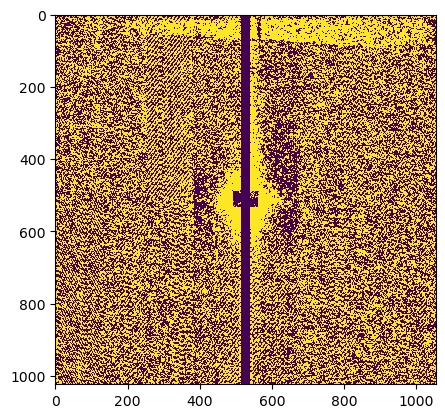

In [8]:
display_image(600)

Provided the sample run is small enough, metrics comparing a run of PiPCA and batch PCA on the supplied data can be computed using the `verify_model_accuracy` method


Verifying Model Accuracy
------------------------

q = 30
d = 1048576
n = 150
m = 15


Gathering images for batch PCA...
Performing batch PCA...


iPCA Normalized Compression Loss: 0.0053049320011508225
PCA Normalized Compression Loss: 0.005303829504187461


iPCA Total Variance: 25543794.834492024
PCA Total Variance: 25543794.834492024


iPCA Explained Variance: 0.41567980424951323
PCA Explained Variance: 0.4160497896656827


iPCA Singular Values: 

[14864.87854262 13915.78813983 12403.75591828 12121.85071988
 10978.29690684  9833.7520409   7401.45199279  7085.25901146
  6654.94893056  6510.59578956  6086.27681971  5817.04481785
  5215.37189803  5137.69914021  4930.91062254  4838.29632757
  4791.31007168  4732.96156244  4545.02121613  4539.54712009
  4516.08130563  4502.13528679  4485.91419498  4480.87684198
  4464.03850545  4455.96946881  4450.07171891  4427.61332875
  4424.66535949  4397.90481288]


PCA Singular Values: 

[14864.91797884 13915.82528657 12403.79554262 12121.89224295


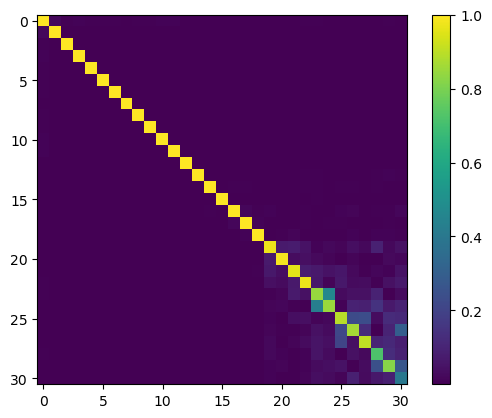





Mean per-batch compute time of step 'record pc data': 0.4774s
Mean per-batch compute time of step 'update mean and variance': 0.1493s
Mean per-batch compute time of step 'center data and compute augment vector': 0.2037s
Mean per-batch compute time of step 'first matrix product U@S': 0.2226s
Mean per-batch compute time of step 'QR concatenate': 0.2144s
Mean per-batch compute time of step 'qr - local qr': 4.704s
Mean per-batch compute time of step 'qr - r_tot gather': 5.85e-05s
Mean per-batch compute time of step 'qr - global qr': 0.0001659s
Mean per-batch compute time of step 'qr - global svd': 0.002034s
Mean per-batch compute time of step 'qr - scatter q_tot': 2.124e-05s
Mean per-batch compute time of step 'qr - local matrix build': 0.509s
Mean per-batch compute time of step 'qr - bcast S_tilde': 1.677e-05s
Mean per-batch compute time of step 'qr - bcast U_tilde': 2.283e-06s
Mean per-batch compute time of step 'parallel QR': 5.216s
Mean per-batch compute time of step 'compute local

In [9]:
ipca.verify_model_accuracy()

Beyond the basics additional functionality for the PiPCA class includes:
- Priming the model using batch PCA before using iPCA. Can be useful for improving model convergence.
- Running the program in benchmarking mode, which drives input parameters to predictable values for consistency in benchmarking.
- Enabling downsampling using pixel binning to decrease image computation overhead. The bin factor is defaulted to 2, but is adjustible.

## CMD use and Parallelization